# **Lab 6 Transfer Learning & Hyperparameter Tuning**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset,Dataset

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
import cv2
from skimage.util import random_noise
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

seed = 4912
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## Data Preparation
Complete the class `CustomImageDataset()` that `__getitem__` return ***noisy blury*** image and ***ground truth*** image.
Please ensure that the final image is in RGBscale and has a size of 128x128.

In [2]:
### START CODE HERE ###
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, gauss_noise=False, gauss_blur=None, resize=128, center_crop=None, p=0.5):
        self.p = p
        self.resize = resize
        self.gauss_noise = gauss_noise
        self.gauss_blur = gauss_blur
        self.center_crop = center_crop
        self.image_paths = image_paths
        
        self.resize_transform = transforms.Resize((self.resize, self.resize))
        if self.center_crop:
            self.center_crop = transforms.CenterCrop(self.center_crop)
        else:
            self.center_crop = None
        self.to_tensor = transforms.ToTensor()
        self.to_pil = transforms.ToPILImage()

    def __len__(self):
        return len(self.image_paths)
    
    def add_gaussian_noise(self, img, mean=0, std=0.25):
        noise = torch.randn(img.size()) * std + mean 
        noisy_img = img + noise
        noisy_img = torch.clamp(noisy_img, 0, 1)
        return noisy_img

    def add_gaussian_blur(self, img):
        blur_transform = transforms.GaussianBlur(kernel_size=(5, 5), sigma=(self.gauss_blur, self.gauss_blur))
        return blur_transform(img)

    def __getitem__(self, idx):
        image_paths = self.image_paths[idx]
        img = Image.open(image_paths).convert("RGB")
        
        gt_image = self.resize_transform(img)
        gt_image = self.to_tensor(gt_image)
        
        
        noisy_img = self.to_pil(gt_image)
        if self.gauss_blur:
            noisy_img = self.add_gaussian_blur(noisy_img)
        if self.gauss_noise:
            noisy_img = self.to_tensor(noisy_img)
            noisy_img = self.add_gaussian_noise(noisy_img)
        else:
            noisy_img = self.to_tensor(noisy_img)

        return noisy_img, gt_image
    
    

### END CODE HERE ###

In [3]:
### START CODE HERE ###
def imshow_grid(images, nrows=4, ncols=4):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))
    fig.set_facecolor('black')
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            img = images[i]
            
            if img.ndim == 2:
                img = img.unsqueeze(0)
            if img.size(0) == 1:    
                img = img.repeat(3, 1, 1)
            
            img = img.permute(1, 2, 0).numpy() 
            img = img * 255 
            ax.imshow(img.astype('uint8'))
            
        ax.axis('off')
    plt.subplots_adjust(left=0.05, right=1.5, bottom=0.02, top=0.95)
    plt.show()
### END CODE HERE ###

In [4]:
### START CODE HERE ###
import glob
data_dir = 'photo'
data_dir = os.path.expanduser('~/blue-workspace/Lab5_CNN/photo/5.2-photo')
image_paths = glob.glob(os.path.join(data_dir, "*.jpg"))
print("Number of images found:", len(image_paths))

dataset = CustomImageDataset(image_paths, gauss_noise=True, resize=128, p=0.5)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
### END CODE HERE ###

Number of images found: 32


Noisy blury images


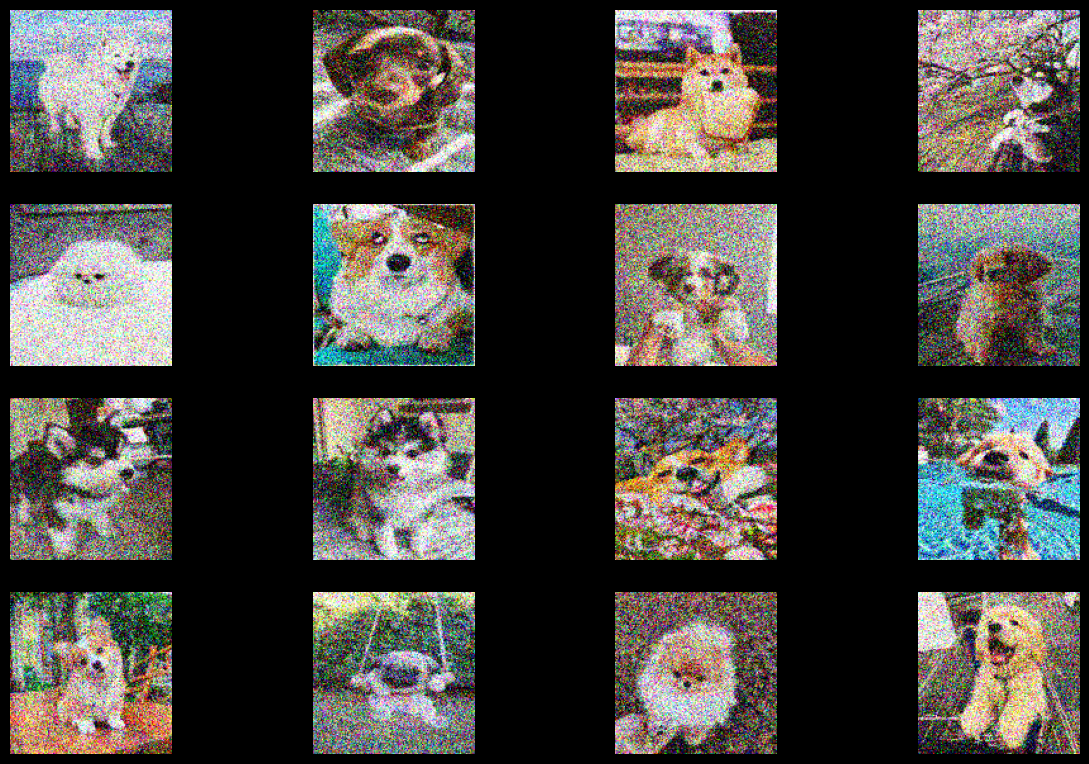

Ground Truth Images


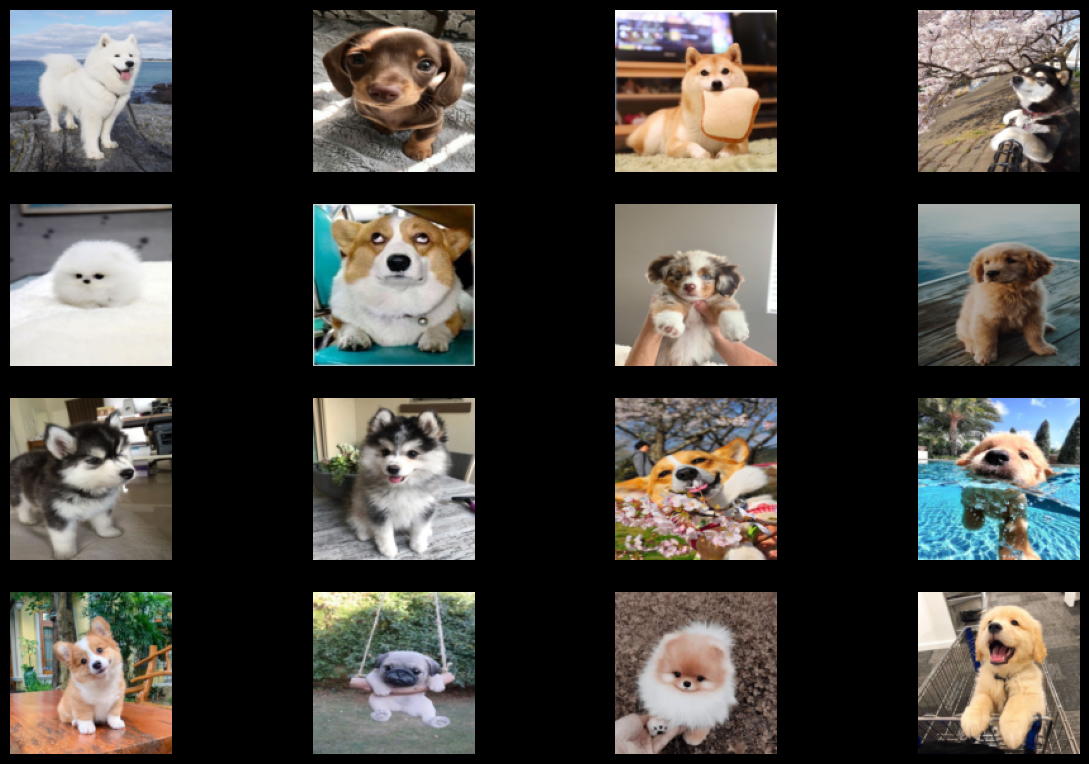

In [5]:
### START CODE HERE ###
batch, gt_img = next(iter(dataloader)) 
print("Noisy blury images")
imshow_grid(batch)
print("Ground Truth Images")
imshow_grid(gt_img)
### END CODE HERE ###

## Create Autoencoder model
You can design your own Autoencoder model with a customizable number of downsampling and upsampling blocks by passing a list of channel numbers for each layer based on the provided code below. However, please maintain the concept of 'Autoencoder'.

In [22]:
### START CODE HERE ###
class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DownSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(UpSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.upsample(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, channels=[64, 128, 256], input_channels=3, output_channels=3):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        
        in_channels = input_channels
        for ch in channels:
            self.encoder.append(DownSamplingBlock(in_channels, ch))
            in_channels = ch
        
        for ch in reversed(channels):
            self.decoder.append(UpSamplingBlock(in_channels, ch))
            in_channels = ch
        
        self.output_conv = nn.Conv2d(in_channels, output_channels, kernel_size=3, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Encoder
        for layer in self.encoder:
            x = layer(x)

        # Decoder
        for layer in self.decoder:
            x = layer(x)
        
        x = self.output_conv(x)
        x = self.sigmoid(x)
        return x

### END CODE HERE ###
        

## Train Autoencoder
Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the ***training loss, test loss,test PSNR, test SSIM***. Additionally, it should save the model at the last epoch.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The log should resemble this, but not be identical

```
🤖Training on cuda
🚀Training Epoch [1/1]: 100%|██████████| 1313/1313 [01:45<00:00, 12.41batch/s, loss=0.0102] 
📄Testing: 100%|██████████| 563/563 [01:10<00:00,  7.95batch/s, loss=0.0106, psnr=16.7, ssim=0.348] 
Summary :
	Train	avg_loss: 0.017262999383663165
	Test	avg_loss: 0.010476540363861867 
                PSNR : 16.839487147468034 
                SSIM : 0.36090552368883694
...
```

</details>

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>), [PSNR & SSIM](https://ieeexplore.ieee.org/document/5596999)

In [23]:
### START CODE HERE ###
def train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu'):
    print("🤖 Training on", device)
    model = model.to(device)
    
    train_losses = [] 
    test_losses = []   
    
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        
        train_bar = tqdm(train_loader, desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        for images, gt in train_bar:
            images, gt = images.to(device), gt.to(device)
            opt.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, gt)
            loss.backward()
            opt.step()

            epoch_train_loss += loss.item()  
            
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss) 
        print(f"Epoch [{epoch+1}/{epochs}] - Training Loss: {avg_train_loss:.4f}")

        model.eval()
        epoch_test_loss = 0.0
        
        test_bar = tqdm(test_loader, desc='📄 Testing', unit='batch')
        with torch.no_grad():  
            for images, gt in test_bar:
                images, gt = images.to(device), gt.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, gt)
                epoch_test_loss += loss.item()
                
                print(f"Output shape: {outputs.shape}, GT shape: {gt.shape}")

        avg_test_loss = epoch_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f"Epoch [{epoch+1}/{epochs}] - Testing Loss: {avg_test_loss:.4f}")

        if checkpoint_path:
            torch.save(model.state_dict(), checkpoint_path)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Over Epochs')
    plt.legend()
    plt.show()  
                
### END CODE HERE ###

Let's train your model with 2 epochs to verify that your train() function works properly. After that, we'll move on to the Hyperparameter Grid Search in the next part.

In [24]:
### START CODE HERE ###
data_dir = os.path.expanduser('~/blue-workspace/Lab5_CNN/photo/5.2-photo')

files = os.listdir(data_dir)
files = [os.path.join(data_dir, file) for file in files]

train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

train_dataset = CustomImageDataset(train_files, gauss_noise=True, resize=128)
test_dataset = CustomImageDataset(test_files, gauss_noise=False, resize=128)

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
### END CODE HERE ###

🤖 Training on cuda


🚀 Training Epoch [1/16]:   0%|          | 0/1 [00:00<?, ?batch/s]

🚀 Training Epoch [1/16]: 100%|██████████| 1/1 [00:01<00:00,  1.20s/batch]


Output shape: torch.Size([25, 3, 128, 128])
Epoch [1/16] - Training Loss: 0.0818


📄 Testing: 100%|██████████| 1/1 [00:00<00:00,  2.96batch/s]


Output shape: torch.Size([7, 3, 128, 128]), GT shape: torch.Size([7, 3, 128, 128])
Epoch [1/16] - Testing Loss: 0.0513


🚀 Training Epoch [2/16]: 100%|██████████| 1/1 [00:01<00:00,  1.83s/batch]


Output shape: torch.Size([25, 3, 128, 128])
Epoch [2/16] - Training Loss: 0.0361


📄 Testing: 100%|██████████| 1/1 [00:00<00:00,  1.68batch/s]


Output shape: torch.Size([7, 3, 128, 128]), GT shape: torch.Size([7, 3, 128, 128])
Epoch [2/16] - Testing Loss: 0.0484


🚀 Training Epoch [3/16]: 100%|██████████| 1/1 [00:01<00:00,  1.63s/batch]


Output shape: torch.Size([25, 3, 128, 128])
Epoch [3/16] - Training Loss: 0.0240


📄 Testing: 100%|██████████| 1/1 [00:00<00:00,  2.98batch/s]


Output shape: torch.Size([7, 3, 128, 128]), GT shape: torch.Size([7, 3, 128, 128])
Epoch [3/16] - Testing Loss: 0.0436


🚀 Training Epoch [4/16]: 100%|██████████| 1/1 [00:01<00:00,  1.76s/batch]


Output shape: torch.Size([25, 3, 128, 128])
Epoch [4/16] - Training Loss: 0.0208


📄 Testing: 100%|██████████| 1/1 [00:00<00:00,  3.06batch/s]


Output shape: torch.Size([7, 3, 128, 128]), GT shape: torch.Size([7, 3, 128, 128])
Epoch [4/16] - Testing Loss: 0.0392


🚀 Training Epoch [5/16]: 100%|██████████| 1/1 [00:01<00:00,  1.16s/batch]


Output shape: torch.Size([25, 3, 128, 128])
Epoch [5/16] - Training Loss: 0.0193


📄 Testing: 100%|██████████| 1/1 [00:00<00:00,  3.39batch/s]


Output shape: torch.Size([7, 3, 128, 128]), GT shape: torch.Size([7, 3, 128, 128])
Epoch [5/16] - Testing Loss: 0.0338


🚀 Training Epoch [6/16]: 100%|██████████| 1/1 [00:01<00:00,  1.98s/batch]


Output shape: torch.Size([25, 3, 128, 128])
Epoch [6/16] - Training Loss: 0.0186


📄 Testing: 100%|██████████| 1/1 [00:00<00:00,  2.03batch/s]


Output shape: torch.Size([7, 3, 128, 128]), GT shape: torch.Size([7, 3, 128, 128])
Epoch [6/16] - Testing Loss: 0.0371


🚀 Training Epoch [7/16]: 100%|██████████| 1/1 [00:01<00:00,  1.71s/batch]


Output shape: torch.Size([25, 3, 128, 128])
Epoch [7/16] - Training Loss: 0.0192


📄 Testing: 100%|██████████| 1/1 [00:00<00:00,  3.12batch/s]


Output shape: torch.Size([7, 3, 128, 128]), GT shape: torch.Size([7, 3, 128, 128])
Epoch [7/16] - Testing Loss: 0.0472


🚀 Training Epoch [8/16]: 100%|██████████| 1/1 [00:01<00:00,  1.58s/batch]


Output shape: torch.Size([25, 3, 128, 128])
Epoch [8/16] - Training Loss: 0.0179


📄 Testing: 100%|██████████| 1/1 [00:00<00:00,  4.07batch/s]


Output shape: torch.Size([7, 3, 128, 128]), GT shape: torch.Size([7, 3, 128, 128])
Epoch [8/16] - Testing Loss: 0.0537


🚀 Training Epoch [9/16]: 100%|██████████| 1/1 [00:01<00:00,  1.68s/batch]


Output shape: torch.Size([25, 3, 128, 128])
Epoch [9/16] - Training Loss: 0.0179


📄 Testing: 100%|██████████| 1/1 [00:00<00:00,  3.31batch/s]


Output shape: torch.Size([7, 3, 128, 128]), GT shape: torch.Size([7, 3, 128, 128])
Epoch [9/16] - Testing Loss: 0.0604


🚀 Training Epoch [10/16]: 100%|██████████| 1/1 [00:01<00:00,  2.00s/batch]


Output shape: torch.Size([25, 3, 128, 128])
Epoch [10/16] - Training Loss: 0.0171


📄 Testing: 100%|██████████| 1/1 [00:00<00:00,  2.00batch/s]


Output shape: torch.Size([7, 3, 128, 128]), GT shape: torch.Size([7, 3, 128, 128])
Epoch [10/16] - Testing Loss: 0.0661


🚀 Training Epoch [11/16]: 100%|██████████| 1/1 [00:01<00:00,  1.88s/batch]


Output shape: torch.Size([25, 3, 128, 128])
Epoch [11/16] - Training Loss: 0.0170


📄 Testing: 100%|██████████| 1/1 [00:00<00:00,  1.72batch/s]


Output shape: torch.Size([7, 3, 128, 128]), GT shape: torch.Size([7, 3, 128, 128])
Epoch [11/16] - Testing Loss: 0.0694


🚀 Training Epoch [12/16]: 100%|██████████| 1/1 [00:00<00:00,  1.72batch/s]


Output shape: torch.Size([25, 3, 128, 128])
Epoch [12/16] - Training Loss: 0.0163


📄 Testing: 100%|██████████| 1/1 [00:00<00:00,  3.24batch/s]


Output shape: torch.Size([7, 3, 128, 128]), GT shape: torch.Size([7, 3, 128, 128])
Epoch [12/16] - Testing Loss: 0.0661


🚀 Training Epoch [13/16]: 100%|██████████| 1/1 [00:01<00:00,  1.67s/batch]


Output shape: torch.Size([25, 3, 128, 128])
Epoch [13/16] - Training Loss: 0.0160


📄 Testing: 100%|██████████| 1/1 [00:00<00:00,  3.04batch/s]


Output shape: torch.Size([7, 3, 128, 128]), GT shape: torch.Size([7, 3, 128, 128])
Epoch [13/16] - Testing Loss: 0.0610


🚀 Training Epoch [14/16]: 100%|██████████| 1/1 [00:01<00:00,  1.46s/batch]


Output shape: torch.Size([25, 3, 128, 128])
Epoch [14/16] - Training Loss: 0.0156


📄 Testing: 100%|██████████| 1/1 [00:00<00:00,  3.27batch/s]


Output shape: torch.Size([7, 3, 128, 128]), GT shape: torch.Size([7, 3, 128, 128])
Epoch [14/16] - Testing Loss: 0.0586


🚀 Training Epoch [15/16]: 100%|██████████| 1/1 [00:02<00:00,  2.52s/batch]


Output shape: torch.Size([25, 3, 128, 128])
Epoch [15/16] - Training Loss: 0.0153


📄 Testing: 100%|██████████| 1/1 [00:00<00:00,  3.07batch/s]


Output shape: torch.Size([7, 3, 128, 128]), GT shape: torch.Size([7, 3, 128, 128])
Epoch [15/16] - Testing Loss: 0.0607


🚀 Training Epoch [16/16]: 100%|██████████| 1/1 [00:01<00:00,  1.79s/batch]


Output shape: torch.Size([25, 3, 128, 128])
Epoch [16/16] - Training Loss: 0.0151


📄 Testing: 100%|██████████| 1/1 [00:00<00:00, 13.43batch/s]

Output shape: torch.Size([7, 3, 128, 128]), GT shape: torch.Size([7, 3, 128, 128])
Epoch [16/16] - Testing Loss: 0.0632


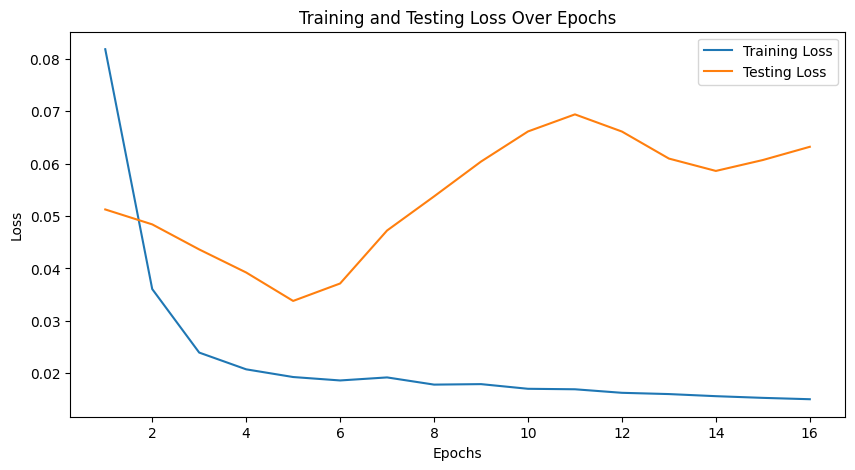

In [25]:
### START CODE HERE ###
model = Autoencoder()
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
train(model, opt, loss_fn, trainloader, testloader, epochs=16, checkpoint_path='autoencoder.pth', device='cuda' if torch.cuda.is_available() else 'cpu')
### END CODE HERE ###

## **Hyperparameter Grid Search with Raytune**

*If you have access to APEX, I would recommend converting this part into a Python file and submitting the job to run on APEX using SBATCH. This process may take a considerable amount of time.*

You can import additional Ray Tune tools as you want, such as schedulers, search algorithms, etc. Further information on the usage of Ray Tune can be found [here](https://docs.ray.io/en/latest/tune/index.html).

---

In [26]:
import ray
print(ray.__version__)

from ray import tune,air
from ray.air import session


ray.shutdown()

2.37.0


Complete the `train_raytune()` function below, following the [quick start guide](https://docs.ray.io/en/latest/tune/index.html). This function will be passed to the `tune.Tuner`.

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.transforms as transforms
# increase vutils
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.utils.tensorboard import SummaryWriter
import copy

import numpy as np
import cv2
import os
import random
from skimage.util import random_noise
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm


In [6]:
### START CODE HERE ###
def train_raytune(config):
    trainloader = DataLoader(config["train_dataset"], batch_size=config["batch_size"])
    testloader = DataLoader(config["test_dataset"], batch_size=config["batch_size"])
    
    model = Autoencoder(channels=config["channels"])

    if config['optimizer'] == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    elif config['optimizer'] == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"])

    report = {}
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    train(model, optimizer, config["loss_fn"], trainloader, testloader, config["epochs"], "raytune/", device=device, report=report)

    session.report(report)

### END CODE HERE ###

Initialize Ray, define the search space, and resources.

Resource : 
- [A Guide To Parallelism and Resources for Ray Tune](https://docs.ray.io/en/latest/tune/tutorials/tune-resources.html#:~:text=A%20Guide%20To%20Parallelism%20and%20Resources%20for%20Ray%20Tune) 
- [Working with Tune Search Spaces](https://docs.ray.io/en/latest/tune/tutorials/tune-search-spaces.html#tune-search-space-tutorial:~:text=Working%20with%20Tune%20Search%20Spaces)
- [How to configure logging in Tune?](https://docs.ray.io/en/latest/tune/tutorials/tune-output.html) 
- [Tune Trial Schedulers (`tune.schedulers`)](https://docs.ray.io/en/latest/tune/api/schedulers.html#tune-scheduler-pbt:~:text=Tune%20Trial...-,Tune%20Trial%20Schedulers%20(tune.schedulers),-%23)

**Search Space:**
- `architecture`:<br>
    Feature map dimensions for convolutional layers<br>
    - `[32, 64, 128]`: 3 downsampling layers with feature maps increasing from 32 to 128.
    - `[64, 128, 256]`: 3 downsampling layers with feature maps starting from 64 to 256.
    - `[64, 128, 256, 512]`: 4 downsampling layers with more depth, starting from 64 and ending at 512.
- `learning rates (lr)`:
    - [1e-3, 8e-4, 1e-4, 1e-2]: Test a wide range of learning rates to evaluate model performance, from 1e-3 (typical) to a more aggressive 1e-2 or conservative 1e-4.
- `batch size`:
    - [16, 32]: Explore smaller batch sizes to evaluate their impact on gradient estimation and memory usage.
- `number of epochs`:
    - `[10, 50, 100]`: Allow short and long training sessions, from quick evaluations (10 epochs) to more extensive training (100 epochs).
- `optimizers (opts)`:
    - `["Adam", "SGD"]`: Compare two popular optimization algorithms: Adam for adaptive learning rates and SGD for momentum-based updates.

In [29]:
### START CODE HERE ###
ray.init(num_gpus=1)
config = {
    "channels": tune.grid_search([
        [32, 64, 128],
        [64, 128, 256],
        [64, 128, 256, 512],
    ]),
    "train_dataset": tune.grid_search([train_dataset]),
    "test_dataset": tune.grid_search([test_dataset]),
    "batch_size": tune.grid_search([16, 32]),
    "optimizer": tune.grid_search(["Adam", "SGD"]),
    "lr": tune.grid_search([1e-3, 8e-4, 1e-4, 1e-2]),
    "epochs": tune.grid_search([10, 50, 100]),
    "loss_fn": tune.grid_search([nn.MSELoss()]),
    # "num_samples": 10
}
tuner = tune.Tuner(
    tune.with_resources(
        train_raytune,
        resources={"gpu": 1, "cpu":30}
    ),
    tune_config = tune.TuneConfig(
        metric = 'val_psnr',
        mode = 'max'
    ),
    param_space = config,
)
result = tuner.fit()
### END CODE HERE ###

2024-09-26 18:41:58,811	WARNING tune_controller.py:2132 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (281 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent pending trials.
2024-09-26 18:41:58,815	WARNING tune_controller.py:2132 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (281 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In this case, consider setting the `TUNE_MAX_PENDING_TRIALS_PG` environment variable to the desired maximum number of concurrent pending trials.
2024-09-26 18:42:19,332	ERROR tune_controller.py:1331 -- Trial task failed for trial train_ray

Restore the result from path of ray resule directory

In [30]:
### START CODE HERE ###
import os
from ray import tune

path = os.path.expanduser('~/ray_results/autoencoder_grid_search')
restored_tuner = tune.Tuner.restore(path, trainable='train_raytune')
### END CODE HERE ###

Get the report from Grid Search to CSV file.

In [31]:
print("🎉[INFO] Training is done!")
print("Best config is:", result.get_best_result(metric="val_loss").config)
print("Best result is:", result.get_best_result(metric="val_loss"))
df = result.get_dataframe()
df.to_csv("ray_tune_results.csv")

2024-09-26 18:42:22,132	WARNING experiment_analysis.py:558 -- Could not find best trial. Did you pass the correct `metric` parameter?


🎉[INFO] Training is done!


RuntimeError: No best trial found for the given metric: val_loss. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

---

Train the Autoencoder models using the best hyperparameter set obtained from the grid search.

In [18]:
### START CODE HERE ###
best_config = result.get_best_result().config

best_model = Autoencoder()
trainloader = DataLoader(CustomImageDataset(train_files, gauss_noise=True, resize=128), batch_size=best_config['batch_size'], shuffle=True)
testloader = DataLoader(CustomImageDataset(test_files, gauss_noise=False, resize=128), batch_size=best_config['batch_size'], shuffle=False)

if best_config['optimizer'] == 'Adam':
    optimizer = optim.Adam(best_model.parameters(), lr=best_config['lr'])
else:
    optimizer = optim.SGD(best_model.parameters(), lr=best_config['lr'], momentum=0.9)

for epoch in range(best_config['num_epochs']):
    best_model.train()
    for inputs, _ in trainloader:
        outputs = best_model(inputs)
        loss = F.mse_loss(outputs, inputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

### END CODE HERE ###

2024-09-26 17:59:43,245	WARNING experiment_analysis.py:558 -- Could not find best trial. Did you pass the correct `metric` parameter?


RuntimeError: No best trial found for the given metric: val_loss. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

Use the `FeatureExtractor()` class and `visualize_feature_map()` function to visualize the feature map of ***ALL*** layers. Then, save it as an image.


In [20]:
import math
class FeatureMapVisualizer:
    def __init__(self, model, layers, save_dir):
        """
        Parameters:
        - model: The PyTorch model
        - layers: A string or list of strings specifying the layer names to visualize
        - save_dir: Directory to save the output feature map images
        """
        self.model = model
        self.layers = layers if isinstance(layers, list) else [layers]
        self.activations = {}
        self.save_dir = save_dir

        os.makedirs(self.save_dir, exist_ok=True)

        self._register_hooks()

    def _register_hooks(self):
        for name, layer in self.model.named_modules():
            if name in self.layers:
                layer.register_forward_hook(self._hook_fn(name))

    def _hook_fn(self, layer_name):
        def hook(module, input, output):
            print(f'Hooking layer: {layer_name}')
            self.activations[layer_name] = output.detach()
        return hook

    def visualize(self, input_paths):
        """
        Pass an input tensor through the model and visualize the activations.
        
        Parameters:
        - input_paths: List of image paths to pass through the model
        """
        
        for img_path in input_paths:
            self.model(img_path)

            for layer_name, activation in self.activations.items():
                print(f'Visualizing and saving layer: {layer_name}')
                self._save_feature_maps(activation, layer_name)

    def _save_feature_maps(self, activation, layer_name):
        ### START CODE HERE ###
        num_channels = activation.shape[1]
        num_cols = math.ceil(math.sqrt(num_channels))
        fig, axs = plt.subplots(num_cols, num_cols, figsize=(12, 12))
        
        for i in range(num_channels):
            ax = axs[i // num_cols, i % num_cols]
            ax.imshow(activation[0, i].cpu(), cmap='gray')
            ax.axis('off')
        
        plt.savefig(os.path.join(self.save_dir, f"{layer_name}_feature_maps.png"))
        plt.close()
        
        ### END CODE HERE ###

In [ ]:
### START CODE HERE ###

visualizer = FeatureMapVisualizer(best_model, ['conv1', 'conv2'], save_dir="feature_maps")
visualizer.visualize(["Sampleimage.jpg"])

### END CODE HERE ###

---
## **Hyperparameter Random Search with Raytune**

**Search Space:**

- **`architecture`:**  
    Define the feature map dimensions for convolutional layers:  
    - `[32, 64, 128]`: 3 downsampling layers with feature maps increasing from 32 to 128.
    - `[64, 128, 256]`: 3 downsampling layers with feature maps starting from 64 to 256.
    - `[64, 128, 256, 512]`: 4 downsampling layers with additional depth, starting from 64 and ending at 512.
  
- **`learning rates (lr)`**:  
    A continuous range of learning rates sampled uniformly between `1e-4` and `1e-2`. This allows exploration of different learning rates from conservative (`1e-4`) to more aggressive (`1e-2`) values.

- **`batch size`**:  
    Randomly sample an integer batch size between 16 and 32 (inclusive). This allows testing of smaller batch sizes, which can affect gradient estimation and memory usage.

- **`number of epochs`**:  
    Randomly sample an integer number of epochs between 10 and 100. This allows the model to train for short (e.g., 10 epochs) or extended periods (up to 100 epochs), giving insight into model performance over different training durations.

- **`optimizers (opts)`**:  
    Randomly select between two optimizers:  
    - `"Adam"`: An adaptive learning rate optimizer that generally performs well across various tasks.  
    - `"SGD"`: Stochastic Gradient Descent with momentum, commonly used for large-scale tasks, requiring careful tuning of the learning rate.

***NOTE*** Random search with 80 samples.

In [ ]:
### START CODE HERE ###
ray.shutdown()
ray.init(num_gpus=1,)

data_dir = "/home/tkrittithee/blue-workspace/Lab6_Hyperparameter-Tuning/data"

files = os.listdir(data_dir)
files = [os.path.join(data_dir, file) for file in files]
file_limit = 280
files = files[:file_limit]

train_files, test_files = train_test_split(files, train_size=0.75, test_size=0.25)

train_dataset = CustomImageDataset(train_files)
test_dataset = CustomImageDataset(test_files)
    
config = {
    "channels": tune.choice([
        [32, 64, 128],
        [64, 128, 256],
        [64, 128, 256, 512],
    ]),
    "train_dataset": train_dataset,
    "test_dataset": test_dataset,
    "batch_size": tune.randint(16, 32 + 1), # make it inclusive
    "optimizer": tune.choice(["Adam", "SGD"]),
    "loss_fn": nn.MSELoss(),
    "epochs": tune.randint(10, 100 + 1), # make it inclusive
    "lr": tune.uniform(1e-4, 1e-2),
}
tuner = tune.Tuner(
    tune.with_resources(
        train_raytune,
        resources={"gpu": 0.5, "cpu":30}
    ),
    tune_config = tune.TuneConfig(
        metric = 'val_psnr',
        mode = 'max',
        num_samples = 80,
    ),
    param_space = config,
    
)
result = tuner.fit()



### END CODE HERE ###

In [ ]:
print("🎉[INFO] Training is done!")
print("Best config is:", result.get_best_result().config)
print("Best result is:", result.get_best_result())
df = result.get_dataframe()
df.to_csv('', index=False)

# ray.shutdown()

---

Train the Autoencoder models using the best hyperparameter set obtained from the random search.

In [ ]:
### START CODE HERE ###



### END CODE HERE ###

Use the `FeatureExtractor()` class and `visualize_feature_map()` function to visualize the feature map of ***ALL*** layers of the Convolution Feature Extractor part. Then, save it as an image.

In [ ]:
### START CODE HERE ###



### END CODE HERE ###

In [ ]:
### START CODE HERE ###

visualizer = FeatureMapVisualizer(None)
visualizer.visualize([None])


### END CODE HERE ###

---

# Questions

1. How many combinations of hyperparameter values (trials) were evaluated during the hyperparameter tuning process?
2. What are the top 3 best parameters and their corresponding tuning results for the model?
3. Analyze and compare the similarities and differences between the top 3 parameters in terms of model architecture, loss, performance, etc.


